In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import make_blobs, make_circles, make_moons 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC as SklearnSVC # Scikit-learn's Support Vector Classifier
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118
NumPy Version: 1.24.3
Scikit-learn Version: 1.2.2


### Introduction to Support Vector Machines (SVMs)

SVMs are powerful supervised learning models used for classification and regression. Key Idea (for classification): Find a hyperplane that best separates the data points of different classes in the feature space. Best separated often means the hyperplane that has the largest margin (distance) to the nearest data points of any class (these points are called support vectors).
- Linearly Separable Data: A linear SVM can find this hyperplane.
- Non-linearly Separable Data: The 'kernel trick' is used to map data into a higher-dimensional space where it might become linearly separable.

### Linearly Separable Data Generation

In [3]:
X_linear, y_linear_np = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=1.0)

In [4]:
X_linear[:5], y_linear_np[:5]

(array([[-2.98837186,  8.82862715],
        [ 5.72293008,  3.02697174],
        [-3.05358035,  9.12520872],
        [ 5.461939  ,  3.86996267],
        [ 4.86733877,  3.28031244]]),
 array([0, 1, 0, 1, 1]))

In [5]:
# For Hinge Loss L = max(0, 1-y_true * y_pred_score), y_true should be -1 or 1.
y_linear_svm_np = np.where(y_linear_np == 0, -1, 1).astype(np.float32)  # convert 0s to -1s

In [7]:
scaler_linear = StandardScaler()
X_linear_scaled = scaler_linear.fit_transform(X_linear)

In [8]:
X_linear_tensor = torch.from_numpy(X_linear_scaled.astype(np.float32))
y_linear_tensor = torch.from_numpy(y_linear_svm_np.reshape(-1,1).astype(np.float32))

In [10]:
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_linear_tensor, y_linear_tensor, test_size=0.25, random_state=42
)

/tmp/ipykernel_1821409/2961865232.py:4: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_train_lin[y_train_lin.squeeze() == 1][:, 0].numpy(), X_train_lin[y_train_lin.squeeze() == 1][:, 1].numpy(),


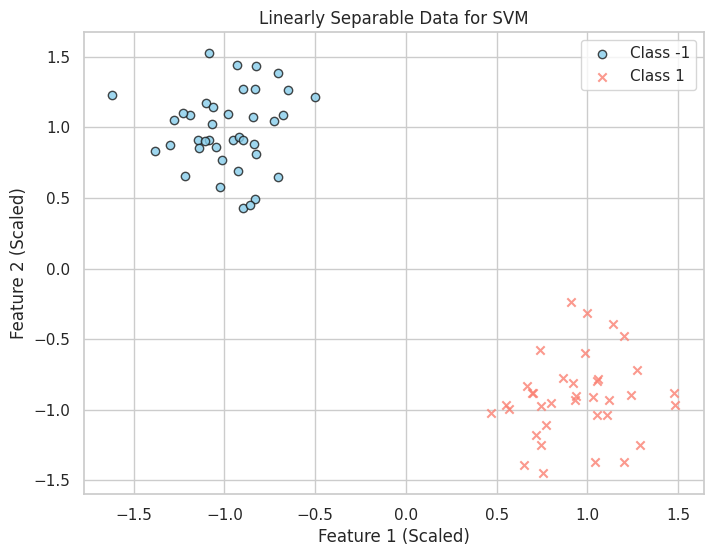

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_lin[y_train_lin.squeeze() == -1][:, 0].numpy(), X_train_lin[y_train_lin.squeeze() == -1][:, 1].numpy(),
            label='Class -1', marker='o', c='skyblue', alpha=0.8, edgecolors='k')
plt.scatter(X_train_lin[y_train_lin.squeeze() == 1][:, 0].numpy(), X_train_lin[y_train_lin.squeeze() == 1][:, 1].numpy(),
            label='Class 1', marker='x', c='salmon', alpha=0.8, edgecolors='k')
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.title("Linearly Separable Data for SVM")
plt.legend()
plt.show()

### Linear SVM with Hinge Loss (PyTorch Gradient Descent Approximation)

<p>The standard SVM optimization problem is typically solved using Quadratic Programming. However, we can approximate a linear SVM by minimizing the Hinge Loss using Gradient Descent. This is often how linear SVMs are implemented in libraries that use SGD (e.g., SGDClassifier in sklearn).</p>
<p>Hinge Loss (for a single sample, with true label y_i in {-1, 1}):
</br>L_i(w, b) = max(0, 1 - y_i * (w^T x_i + b))
</br>The term (w^T x_i + b) is the "score" or "decision function" output.</p>
<p>Total Cost (often with an L2 regularization term for the weights, similar to Ridge):
</br>J(w, b) = C * (1/N) * Σ_i max(0, 1 - y_i * (w^T x_i + b)) + (1/2) * ||w||^2

- C is a regularization parameter (inverse of alpha/lambda in Ridge). Large C = less regularization.
- (1/2) * ||w||^2 is the L2 regularization term on weights (to maximize margin, equivalent to minimizing ||w||^2).
</p>

In [13]:
# Model parameters and hyperparameters
n_features_lin = X_train_lin.shape[1]
weights_svm_manual = torch.randn(n_features_lin, 1, requires_grad=True, dtype=torch.float32)
bias_svm_manual = torch.randn(1, requires_grad=True, dtype=torch.float32)

learning_rate_svm = 0.01
num_epochs = 500
c_regularization = 1.0  # Regulariation strength

In [15]:
loss_history_svm_manual = []
for epoch in range(num_epochs):
    # compute decision function output (scores)
    scores = X_train_lin @ weights_svm_manual + bias_svm_manual     # --> [N_samples, 1]
    # compute hinge loss 
    # L_i = max(0, 1 - y_i * score_i)
    hinge_losses = torch.relu(1 - y_train_lin * scores)     # relu(x) = max(0, x)
    data_loss = torch.mean(hinge_losses)
    # compute regularization term (||w||^2 / (2C) or lambda * ||w||^2)
    # so data_loss_term = C_REGULARIZATION * data_loss
    # and reg_loss_term = 0.5 * torch.sum(weights_svm_manual**2)
    # total_loss = data_loss_term + reg_loss_term

    # Alternative: J(w,b) = (1/N) * sum(hinge_losses) + lambda_param * sum(w^2)
    # Let's use lambda formulation as it's easier to see the L2 penalty directly
    lambda_param = 1 / (2 * c_regularization) if c_regularization > 0 else 0    # lambda = 1/(2C)
    reg_loss = lambda_param * torch.sum(weights_svm_manual**2)
    total_loss = data_loss + reg_loss

    loss_history_svm_manual.append(total_loss.item())

    # backward pass
    if weights_svm_manual.grad is not None: weights_svm_manual.grad.zero_()
    if bias_svm_manual.grad is not None: bias_svm_manual.grad.zero_()
    total_loss.backward()

    # update parameters
    with torch.no_grad():
        weights_svm_manual -= learning_rate_svm * weights_svm_manual.grad
        bias_svm_manual -= learning_rate_svm * bias_svm_manual.grad

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.4f}, "
              f"Data Loss: {data_loss.item():.4f}, Reg Loss: {reg_loss.item():.4f}")

Epoch [100/500], Total Loss: 0.3728, Data Loss: 0.1008, Reg Loss: 0.2721
Epoch [200/500], Total Loss: 0.3473, Data Loss: 0.0883, Reg Loss: 0.2590
Epoch [300/500], Total Loss: 0.3446, Data Loss: 0.0914, Reg Loss: 0.2532
Epoch [400/500], Total Loss: 0.3442, Data Loss: 0.0934, Reg Loss: 0.2508
Epoch [500/500], Total Loss: 0.3442, Data Loss: 0.0938, Reg Loss: 0.2504


In [21]:
weights_svm_manual.flatten().data, bias_svm_manual.item()

(tensor([ 0.5143, -0.4865]), 0.030471589416265488)

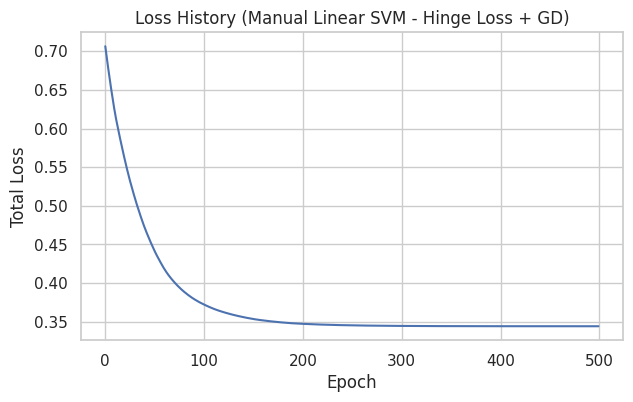

In [22]:
plt.figure(figsize=(7,4))
plt.plot(loss_history_svm_manual)
plt.title("Loss History (Manual Linear SVM - Hinge Loss + GD)")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.show()

In [27]:
# Plot Decision Boundary for Manual Linear SVM
def plot_svm_decision_boundary(X_data, y_data, weights, bias, title="SVM Decision Boundary"):
    plt.figure(figsize=(8,6))
    plt.scatter(X_data[y_data.squeeze() == -1][:, 0], X_data[y_data.squeeze() == -1][:, 1],
                label='Class -1', marker='o', c='skyblue', alpha=0.8, edgecolors='k')
    plt.scatter(X_data[y_data.squeeze() == 1][:, 0], X_data[y_data.squeeze() == 1][:, 1],
                label='Class 1', marker='x', c='salmon', alpha=0.8, edgecolors='k')

    # Ensure weights and bias are tensors
    w = weights.detach() if isinstance(weights, torch.Tensor) else torch.tensor(weights, dtype=torch.float32)
    b = bias.detach() if isinstance(bias, torch.Tensor) else torch.tensor(bias, dtype=torch.float32)

    # Create a mesh to plot decision boundary and margins
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = (xy @ w.numpy().reshape(-1,1) + b.numpy()).reshape(XX.shape) # Decision function scores

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Highlight support vectors (approximate for GD version)
    decision_values = X_data @ w + b
    support_vectors_mask = (torch.abs(1 - y_data * decision_values) < 0.1) # Looser tolerance for GD
    plt.scatter(X_data[support_vectors_mask.squeeze()][:, 0].numpy(),
                X_data[support_vectors_mask.squeeze()][:, 1].numpy(),
                s=100, facecolors='none', edgecolors='green', label='Approx. Support Vectors (GD)')

    plt.xlabel("Feature 1 (Scaled)")
    plt.ylabel("Feature 2 (Scaled)")
    plt.title(title)
    plt.legend()
    plt.show()
    

/tmp/ipykernel_1821409/485443065.py:6: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_data[y_data.squeeze() == 1][:, 0], X_data[y_data.squeeze() == 1][:, 1],


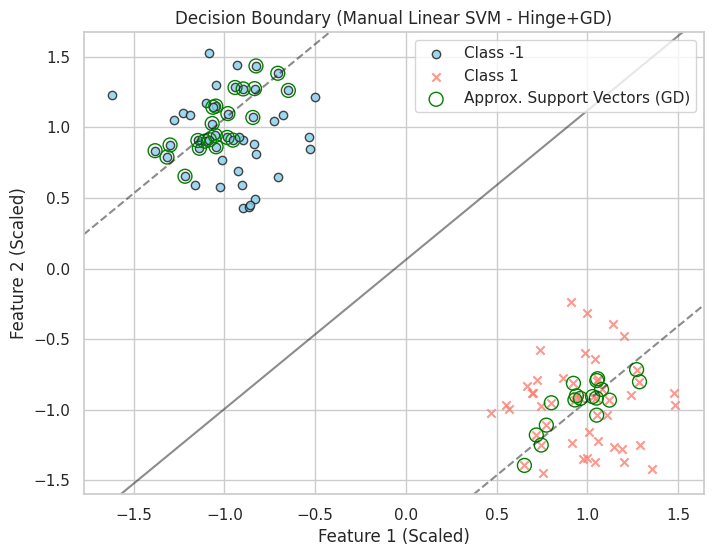

In [28]:
plot_svm_decision_boundary(X_linear_tensor, y_linear_tensor, weights_svm_manual, bias_svm_manual,
                           "Decision Boundary (Manual Linear SVM - Hinge+GD)")

### The Kernel Trick and Non-Linear SVMs

<h5>What if data is not linearly separable?</h5>
<p>The "kernel trick": Map data into a higher-dimensional feature space where it might become linearly separable, without explicitly computing the coordinates in that high-dimensional space.</p>
<p>Instead, we define a kernel function K(x_i, x_j) that computes the dot product of the transformed feature vectors φ(x_i) . φ(x_j) in the higher-dimensional space.</p>

<b>Common Kernels:</b>
- Linear: K(x_i, x_j) = x_i^T x_j (equivalent to no transformation)
- Polynomial: K(x_i, x_j) = (γ * x_i^T x_j + r)^d
    - Parameters: d (degree), γ (gamma), r (coef0)
- Radial Basis Function (RBF) / Gaussian: K(x_i, x_j) = exp(-γ * ||x_i - x_j||^2)
    - Parameter: γ (gamma). Controls the influence of a single training example.
    - Small gamma: large radius of influence (smoother boundary).
    - Large gamma: small radius of influence (more complex, potentially wiggly boundary).


In [29]:
# Generate Non-Linearly Separable Data 
X_circle, y_circle_np = make_circles(n_samples=150, noise=0.1, factor=0.5, random_state=42)
y_circle_svm_np = np.where(y_circle_np == 0, -1, 1).astype(np.float32)

In [30]:
scaler_circle = StandardScaler()
X_circle_scaled = scaler_circle.fit_transform(X_circle)

In [31]:
X_circle_tensor = torch.from_numpy(X_circle_scaled.astype(np.float32))
y_circle_tensor = torch.from_numpy(y_circle_svm_np.reshape(-1,1).astype(np.float32))

/tmp/ipykernel_1821409/2766973867.py:4: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_circle_scaled[y_circle_svm_np == 1][:, 0], X_circle_scaled[y_circle_svm_np == 1][:, 1],


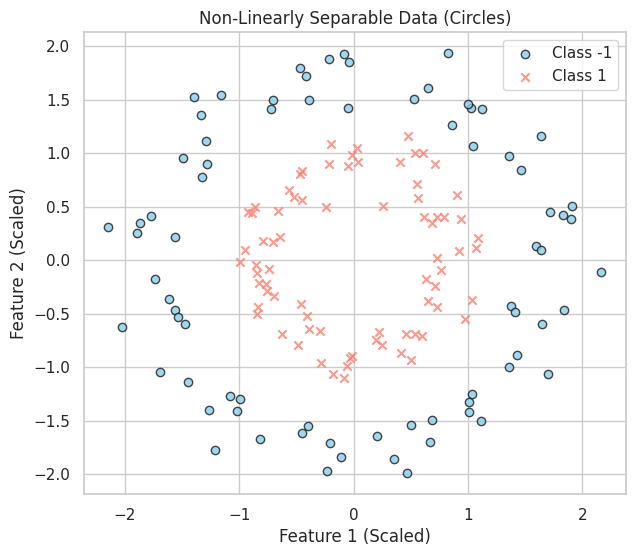

In [32]:
plt.figure(figsize=(7, 6))
plt.scatter(X_circle_scaled[y_circle_svm_np == -1][:, 0], X_circle_scaled[y_circle_svm_np == -1][:, 1],
            label='Class -1', marker='o', c='skyblue', alpha=0.8, edgecolors='k')
plt.scatter(X_circle_scaled[y_circle_svm_np == 1][:, 0], X_circle_scaled[y_circle_svm_np == 1][:, 1],
            label='Class 1', marker='x', c='salmon', alpha=0.8, edgecolors='k')
plt.xlabel("Feature 1 (Scaled)"); 
plt.ylabel("Feature 2 (Scaled)")
plt.title("Non-Linearly Separable Data (Circles)"); 
plt.legend(); 
plt.show()

In [38]:
def plot_sklearn_svm_boundary(ax, model, X_data_np, title):
    # mesh to plot decision bonudary
    xlim = X_data_np[:,0].min() - 0.5, X_data_np[:,0].max() + 0.5
    ylim = X_data_np[:,1].min() - 0.5, X_data_np[:,1].max() + 0.5
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)   # Decision function scores

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='green', label='Support Vectors')
    ax.set_title(title)
    ax.legend(fontsize='small')

In [39]:
X_sk = X_circle_scaled
y_sk = y_circle_svm_np

In [40]:
# kernel 1: Linear (should fail on circle data)
svm_linear_sk = SklearnSVC(kernel='linear', C=1.0)
svm_linear_sk.fit(X_sk, y_sk)

SVC(kernel='linear')

In [41]:
# kernel 2: Polynomial
svm_poly_sk = SklearnSVC(kernel="poly", degree=3, gamma="scale", C=1.0, coef0=1)    # coef0 for poly
svm_poly_sk.fit(X_sk, y_sk)

SVC(coef0=1, kernel='poly')

In [42]:
# kernel 3: RBF (Gaussian)
svm_rbf_sk = SklearnSVC(kernel='rbf', gamma=0.7, C=1.0)     # gamma is crucial for RBF
svm_rbf_sk.fit(X_sk, y_sk)

SVC(gamma=0.7)

/tmp/ipykernel_1821409/274109716.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_sk[y_sk == 1][:, 0], X_sk[y_sk == 1][:, 1],


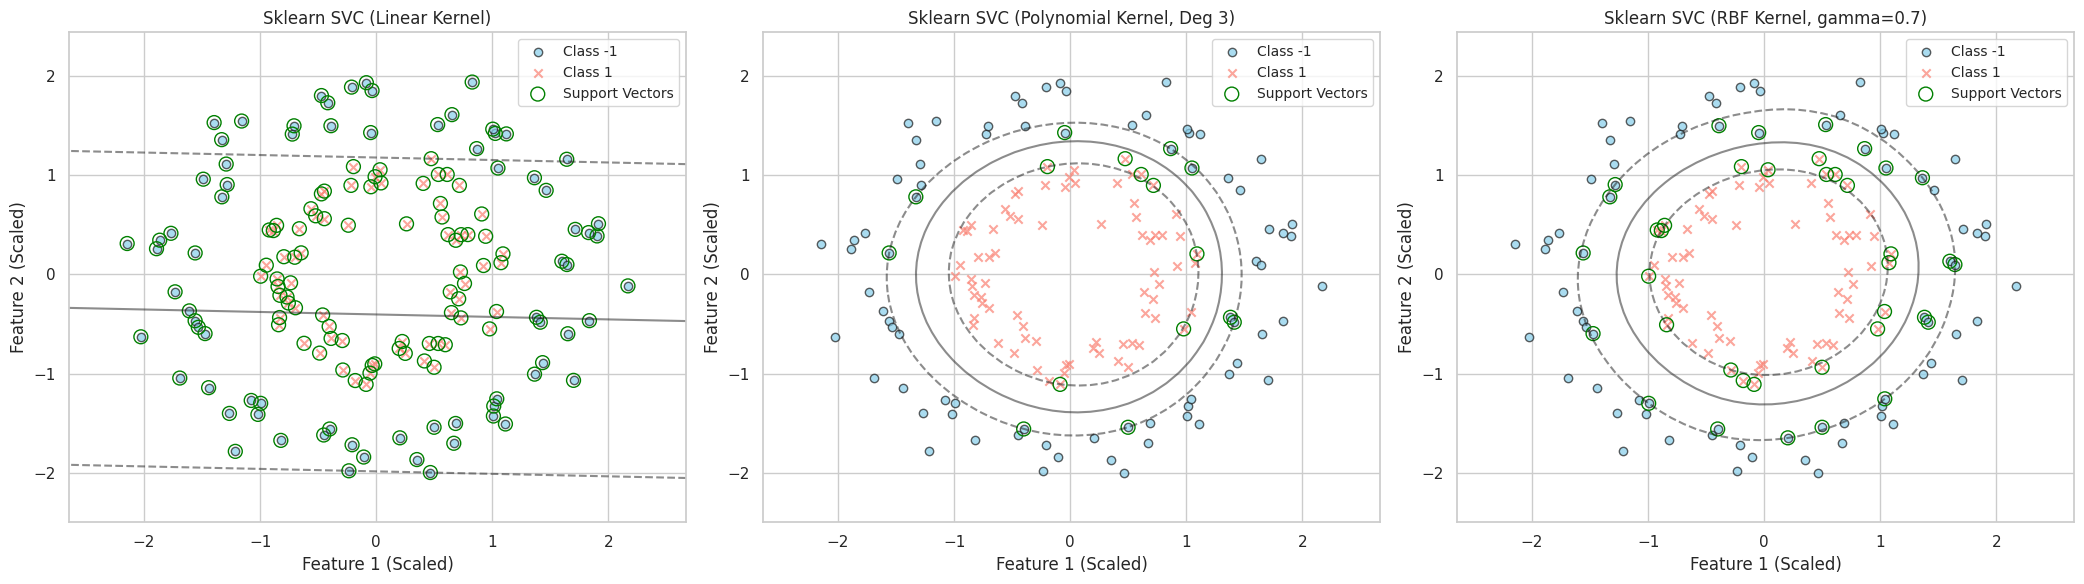

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Plot data points on each subplot
for ax in axes:
    ax.scatter(X_sk[y_sk == -1][:, 0], X_sk[y_sk == -1][:, 1],
               label='Class -1', marker='o', c='skyblue', alpha=0.7, edgecolors='k')
    ax.scatter(X_sk[y_sk == 1][:, 0], X_sk[y_sk == 1][:, 1],
               label='Class 1', marker='x', c='salmon', alpha=0.7, edgecolors='k')
    ax.set_xlabel("Feature 1 (Scaled)"); ax.set_ylabel("Feature 2 (Scaled)")

plot_sklearn_svm_boundary(axes[0], svm_linear_sk, X_sk, "Sklearn SVC (Linear Kernel)")
plot_sklearn_svm_boundary(axes[1], svm_poly_sk, X_sk, "Sklearn SVC (Polynomial Kernel, Deg 3)")
plot_sklearn_svm_boundary(axes[2], svm_rbf_sk, X_sk, "Sklearn SVC (RBF Kernel, gamma=0.7)")

plt.tight_layout(); 
plt.show()


**Observations**
- Linear kernel fails to separate the circular data.
- Polynomial and RBF kernels can find non-linear decision boundaries.
- Hyperparameters (C, gamma, degree, coef0) are important for kernel SVMs and often require tuning

### Model Evaluation (for Linear SVM Approximation)

In [56]:
def evaluate_svm_manual(X_test_data, y_test_data, weights, bias, model_name="Manual SVM"):
    with torch.no_grad():
        scores = X_test_data @ weights + bias
        # Predictions: sign of scores (since y_true is -1 or 1)
        y_pred_binary = torch.sign(scores)
        # Ensure y_pred_binary doesn't have zeros if scores are exactly 0; map 0 to 1 (or -1)
        y_pred_binary[y_pred_binary == 0] = 1

    accuracy = accuracy_score(y_test_data.flatten(), y_pred_binary.flatten())
    # Precision, Recall, F1 for {-1,1} might need pos_label argument or careful interpretation

    print(f"  Accuracy on Test Set: {accuracy:.4f}")
    cm = confusion_matrix(y_test_data.flatten(), y_pred_binary.flatten(), labels=[-1,1]) # Specify labels for {-1,1}
    print(f"  Confusion Matrix (labels {-1, 1}):\n{cm}")

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Class -1', 'Pred Class 1'],
                yticklabels=['Actual Class -1', 'Actual Class 1'])
    plt.title(f'CM - {model_name}')
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()
    return accuracy


  Accuracy on Test Set: 1.0000
  Confusion Matrix (labels (-1, 1)):
[[11  0]
 [ 0 14]]


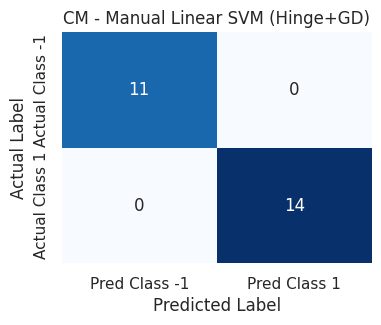

1.0

In [57]:
evaluate_svm_manual(X_test_lin, y_test_lin, weights_svm_manual, bias_svm_manual,
                    "Manual Linear SVM (Hinge+GD)")

In [58]:
# Evaluation for sklearn models (on circle data as an example)
acc_linear_sk = accuracy_score(y_sk, svm_linear_sk.predict(X_sk))
acc_poly_sk = accuracy_score(y_sk, svm_poly_sk.predict(X_sk))
acc_rbf_sk = accuracy_score(y_sk, svm_rbf_sk.predict(X_sk))
print(f"\nSklearn SVC (Linear Kernel) Accuracy on Circle Data: {acc_linear_sk:.4f}")
print(f"Sklearn SVC (Poly Kernel) Accuracy on Circle Data: {acc_poly_sk:.4f}")
print(f"Sklearn SVC (RBF Kernel) Accuracy on Circle Data: {acc_rbf_sk:.4f}")


Sklearn SVC (Linear Kernel) Accuracy on Circle Data: 0.5667
Sklearn SVC (Poly Kernel) Accuracy on Circle Data: 1.0000
Sklearn SVC (RBF Kernel) Accuracy on Circle Data: 1.0000


#### Conclusion
- SVMs aim to find a maximal margin hyperplane.
- Linear SVMs use Hinge Loss (often with L2 regularization) which can be optimized approximately with Gradient descent.
- The Kernel Trick allows SVMs to find non-linear decision boundaries by implicitly mapping data to higher dimensions (Polynomial, RBF kernels are common).
- Full kernel SVM optimization is complex (often QP or SMO); libraries like scikit-learn provide robust implementations
- Hyperparameter tuning (C, kernel type, kernel parameters like gamma, degree) is crucial for SVMs